In [1]:
#パッケージのインポート
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

/opt/conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#乱数のシード設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
#入力画像の前処理クラス
#訓練時と推論時で処理が異なる
class ImageTransform():
    """画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train" : transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)), #データオーギュメンテーション
                transforms.RandomHorizontalFlip(), #データオーギュメンテーション
                transforms.ToTensor(), #テンソルに変換
                transforms.Normalize(mean, std) #標準化
                ]),
            "val" : transforms.Compose([
                transforms.Resize(resize), #リサイズ
                transforms.CenterCrop(resize), #中央をresize×resizeで切り取り
                transforms.ToTensor(), #テンソルに変換
                transforms.Normalize(mean, std) #標準化
            ])
        }
    
    def __call__(self, img, phase="train"):
        """
        
        Parameters

        ----------
        phase: "train" or "val"
            前処理のモードを指定。
        """

        return self.data_transform[phase](img)

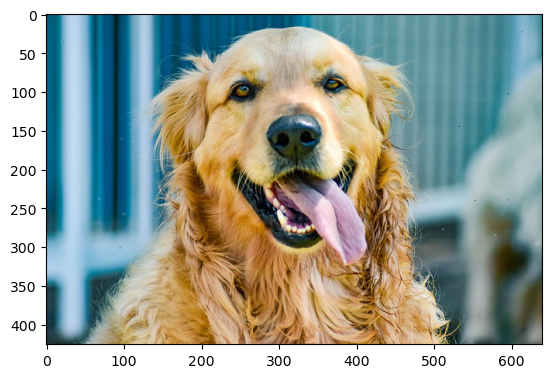

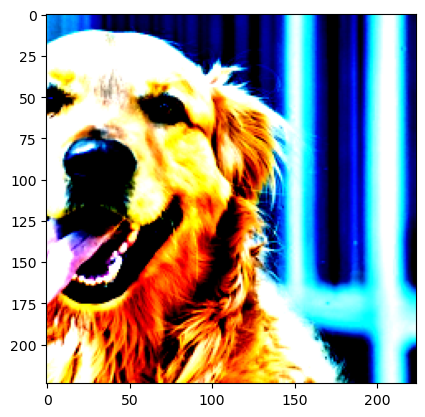

In [4]:
#訓練時の画像前処理の動作を確認
#実行するたびに処理結果の画像が変わる

# 1. 画像の読み込み
image_file_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path) # [高さ][幅][色RGB]

# 2. 元画像の表示
plt.imshow(img)
plt.show()

# 3.画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406) 
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize=size, mean=mean, std=std)
img_transformed = transform(img, phase="train")

# 4. (色、幅、高さ)を（高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [5]:
#アリとハチの画像へのファイルパスリストを作成する

def make_datapath_list(phase="train"):
    """
    データへのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : "train" or "val"
        訓練データか検証データかを設定する。
    Returns
    -------
    path_list : list
        データへのパスを格納したリスト。
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath + phase + "/**/*.jpg")
    print(target_path)

    path_list = [] #ここに格納する

    #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

#実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")
train_list
val_list



./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/val/ants/10308379_1b6c72e180.jpg',
 './data/hymenoptera_data/val/ants/1053149811_f62a3410d3.jpg',
 './data/hymenoptera_data/val/ants/1073564163_225a64f170.jpg',
 './data/hymenoptera_data/val/ants/1119630822_cd325ea21a.jpg',
 './data/hymenoptera_data/val/ants/1124525276_816a07c17f.jpg',
 './data/hymenoptera_data/val/ants/11381045_b352a47d8c.jpg',
 './data/hymenoptera_data/val/ants/119785936_dd428e40c3.jpg',
 './data/hymenoptera_data/val/ants/1247887232_edcb61246c.jpg',
 './data/hymenoptera_data/val/ants/1262751255_c56c042b7b.jpg',
 './data/hymenoptera_data/val/ants/1337725712_2eb53cd742.jpg',
 './data/hymenoptera_data/val/ants/1358854066_5ad8015f7f.jpg',
 './data/hymenoptera_data/val/ants/1440002809_b268d9a66a.jpg',
 './data/hymenoptera_data/val/ants/147542264_79506478c2.jpg',
 './data/hymenoptera_data/val/ants/152286280_411648ec27.jpg',
 './data/hymenoptera_data/val/ants/153320619_2aeb5fa0ee.jpg',
 './data/hymenoptera_data/val/ants/153783656_85f9c3ac70.jpg',
 

In [6]:
#アリとハチの画像のDatasetを作成する

class HymenpoteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト。
    transform : object
        前処理のクラスのインスタンス。
    phase : "train" or "test"
        訓練か検証かを設定する。
    """
    
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list #ファイルパスのリスト
        self.transform = transform #前処理のクラスのインスタンス
        self.phase = phase #train or valの指定

    def __len__(self):
        "画像の枚数を返す"
        return len(self.file_list)
    def __getitem__(self,index):
        """
        前処理した画像のTensor形式のデータとラベルを取得
        """

        #index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path) # [高さ][幅][色RGB]

        #画像の前処理を実施
        img_transformed = self.transform(img, self.phase) #torch.Size([3, 224, 224])

        #画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        
        #ラベルを数値に変換する
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


In [7]:
#実行
train_dataset = HymenpoteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase="train")

val_dataset = HymenpoteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase="val")

#動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size()) #torch.Size([3, 224, 224])
print(train_dataset.__getitem__(index)[1]) #0 or 1

torch.Size([3, 224, 224])
0


In [8]:
#ミニバッチサイズの指定
batch_size = 32

#DataLoaderの作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#辞書型変数にまとめる
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

#動作確認
batch_iterator = iter(dataloaders_dict["train"]) #イテレータに変換
inputs, labels = next(batch_iterator) #1番目の要素を取り出す
print(inputs.size()) #torch.Size([32, 3, 224, 224])
print(labels) 

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


In [9]:
#学習済みのモデルをロードする
#VGG16のインスタンスを生成
use_pretrained = True #学習済みのパラメータを使用する
net = models.vgg16(pretrained=use_pretrained)

#VGG16の最後の出力層の出力ユニット数をアリとハチの2つの出力に変更
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

#訓練モードに設定
net.train()

print("ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました。")

/opt/conda/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました。


In [10]:
#損失関数の設定
criterion = nn.CrossEntropyLoss()

In [11]:
#転移学習で学習させるパラメータを変数params_to_updateに格納する
params_to_update = []

#学習させるパラメータ名を指定
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

#学習させるパラメーター以外は勾配計算をなくし、学習させないようにする
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False    
#params_to_updateの中身を確認
print("-------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-------------
[Parameter containing:
tensor([[-0.0133, -0.0051, -0.0067,  ...,  0.0068, -0.0040,  0.0070],
        [ 0.0063, -0.0014,  0.0149,  ..., -0.0018, -0.0116, -0.0079]],
       requires_grad=True), Parameter containing:
tensor([-0.0020, -0.0065], requires_grad=True)]


In [12]:
#最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [13]:
#モデルを訓練させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    #epochのループ
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("-------------")

        #epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train() #モデルを訓練モードに
            else:
                net.eval() #モデルを検証モードに
        
            epoch_loss = 0.0 #epochの損失和
            epoch_corrects = 0 #epochの正解数

            #未学習時の検証性能を確かめるため、epoch=0のときは訓練は省略
            if (epoch == 0) and (phase == "train"):    
                continue

            #データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #optimizerを初期化
                optimizer.zero_grad()

                #順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) #損失を計算
                    _, preds = torch.max(outputs, 1) #ラベルを予測

                    #訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    #イテレーション結果の計算
                    #lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    #正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            #epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)  
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

In [14]:
#学習の検証を実行する
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


val Loss: 0.7191 Acc: 0.4967
Epoch 2/2
-------------


100%|██████████| 8/8 [00:32<00:00,  4.05s/it]


train Loss: 0.4730 Acc: 0.7407


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]

val Loss: 0.1683 Acc: 0.9542
